In [24]:
!pip install mat73 opencv-python numpy scipy matplotlib statannotations scikit-learn seaborn plotly umap-learn hdbscan torch torchvision tqdm scprep 
!pip install igraph leidenalg 
!python -m pip install -U "pandas>=2.2"
!pip install --upgrade pip

  Using cached scprep-1.2.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached pandas-2.0.3.tar.gz (5.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached scprep-1.2.3-py3-none-any.whl (94 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2821 lines of output]
      <string>:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
      /private/var/folders/cx/tm2pf2dj071426f9zly3d3w00000gp/T/pip-build-env-9qwrnnim/overlay/lib/python3.13/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              *********

In [23]:
import sys 
# sys.path.append('/mnt/merlin_bio/microfluidic_chips/PBMCs_good/chrometrics/')
import os
os.environ["SCIPY_ARRAY_API"] = "1" 
import time

import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
import image.loadImage as loadImage
import image.modelsCNN as modelsCNN
import optimizer as optimizer
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import utilities 
import umap
import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph

ModuleNotFoundError: No module named 'igraph'

# Make 2D projections of equal sizes and store it by pathology

[28 36 29 ... 23 22 23]
[29 44 33 ... 26 23 23]


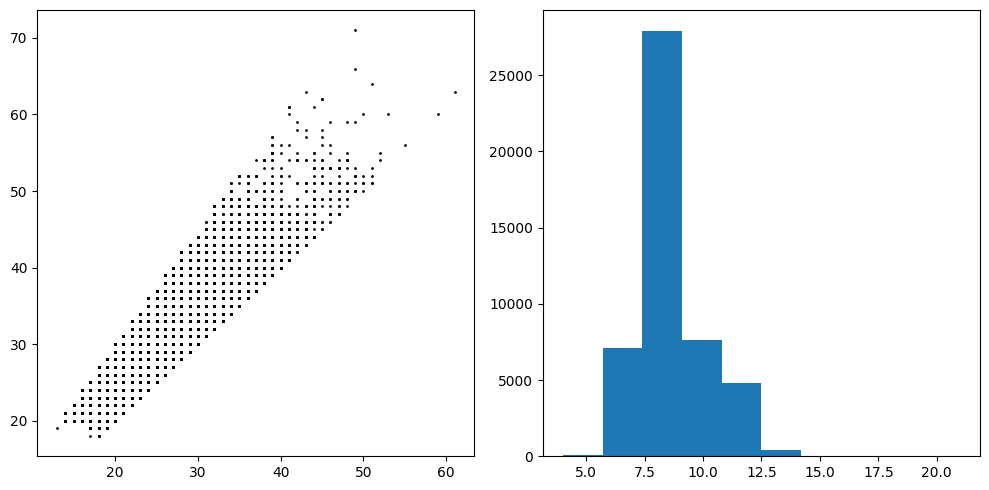

61
71


In [5]:
nmco_features_filtered=pd.read_csv('nmco_features_filtered_with_qc_3rd_july_2024.csv')
with open('raw_images.pkl', 'rb') as f:
    raw_images = pickle.load(f)    
with open('raw_images_cleaned.pkl', 'rb') as f:
    raw_images_cleaned = pickle.load(f)    

size_max_mat=[]
size_min_mat=[]
size_z_mat=[]

for image in raw_images_cleaned: 
    size_max=np.max(np.shape(np.max(image,0)),0)
    size_max_mat.append(size_max)
    size_min=np.min(np.shape(np.max(image,0)),0)
    size_min_mat.append(size_min)
    size_z=np.shape(image)[0]
    size_z_mat.append(size_z)
        

size_min_mat=np.asarray(size_min_mat)
size_max_mat=np.asarray(size_max_mat)

print(size_min_mat)
print(size_max_mat)
# AR=size_max_mat/size_min_mat
# area=size_max_mat*size_max_mat

fig, ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
ax[0].scatter(size_min_mat, size_max_mat, s=1, marker='o', c='black')
ax[1].hist(size_z_mat, bins=10)
plt.show()

print(np.max(size_min_mat,0))
print(np.max(size_max_mat,0))



boolean_live_qc_filter= np.logical_and(np.asarray(nmco_features_filtered['live_dead_test']=="live")
                                      ,np.asarray(nmco_features_filtered['quality_check']==False))

#boolean_live_qc_filter=np.logical_and(boolean_live_qc_filter,nmco_features_filtered['NMprojboundrectht']*4>64)
#boolean_live_qc_filter=np.logical_and(boolean_live_qc_filter,nmco_features_filtered['NMprojboundrectwd']*4>64)   
    

In [6]:
nmco_features_filtered

,Unnamed: 0.1,Unnamed: 0,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,d25_radius,...,HOstdnodevol,HOtotnodevol,patient_id,constriction_size,disease,disease_constric,patient_id_constric,quality_check,live_dead_test,% Live Dead
0,0,0,25,51,0.490196,10.687987,25.917468,18.844255,18.205897,13.248948,...,7.4228,34.6875,2,compressed,Healthy,Healthy_compressed,2_compressed,True,live,1
1,1,1,24,28,0.857143,9.810235,14.222918,12.255284,12.243031,11.700826,...,2.3976,14.9375,2,compressed,Healthy,Healthy_compressed,2_compressed,False,live,1
2,2,2,27,43,0.627907,9.269943,21.610649,17.190282,16.552340,13.780295,...,22.3623,31.7500,2,compressed,Healthy,Healthy_compressed,2_compressed,False,live,1
3,3,3,42,49,0.857143,17.245884,24.121200,21.256599,21.221101,20.343372,...,34.7674,60.6875,2,compressed,Healthy,Healthy_compressed,2_compressed,False,dead,1
4,4,4,40,45,0.888889,18.143021,22.249060,20.158638,20.275595,19.470984,...,9.8096,40.0000,2,compressed,Healthy,Healthy_compressed,2_compressed,False,dead,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57621,57621,57621,19,22,0.863636,4.340074,10.592360,9.439398,9.005676,8.323051,...,3.3864,13.1875,91,control,Prediabetic,Prediabetic_control,91_control,False,live,1
57622,57622,57622,19,23,0.826087,8.357401,10.992710,9.412424,9.510942,8.914627,...,5.1333,14.4375,91,control,Prediabetic,Prediabetic_control,91_control,False,live,1
57623,57623,57623,19,25,0.760000,8.552822,11.944416,9.974703,10.189871,9.317599,...,3.7901,14.4375,91,control,Prediabetic,Prediabetic_control,91_control,False,live,1
57624,57624,57624,17,23,0.739130,7.146587,11.492029,8.795618,9.092508,8.176941,...,2.0952,10.4375,91,control,Prediabetic,Prediabetic_control,91_control,False,live,1


In [7]:
size_image=128 # defining the size of the image based on the maximum size if the entire dataset
nchannels=1
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
seed=3
imageslist={}
imagesid={}
whereid={}
for entry in np.unique(nmco_features_filtered['disease_constric']):
    clean_image_indices=np.where(np.logical_and(np.asarray(nmco_features_filtered['disease_constric']
                                                       ==entry),boolean_live_qc_filter))
    where_index=clean_image_indices[0]
    pid_cons=nmco_features_filtered['patient_id_constric'][clean_image_indices[0]]
    raw_images_cleaned=[raw_images[i] for i in clean_image_indices[0]]
    output=utilities.uniform_and_split_images(size_image,nchannels,raw_images_cleaned,pid_cons,where_index,seed,testNodes,valNodes,minmaxscale=True)
    imageslist[entry]=output[0:3]
    imagesid[entry]=output[3:6]
    whereid[entry]=output[6:9]

6061
8124
10485
8945
1893
982
4392
7145


In [4]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=5000
saveFreq=20
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=100
kernel_size=4
stride=2
padding=1

hidden1=128 #Number of channels in hidden layer 1
hidden2=256 
hidden3=512
hidden4=1024
hidden5=1024
fc_dim1=1024*4*4
fc_dim2=1024
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# clfweight=20
advWeight=2
# randFeatureSubset=None
kl_weight=0.0000001
model_str='cnn_vae'
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'

name='all_thresh12min6_02_overlap15'
logsavepath='/mnt/merlin_bio/microfluidic_chips/log/train_cnn_starmap/'+name
modelsavepath='/mnt/merlin_bio/microfluidic_chips/models/train_cnn_starmap/'+name
plotsavepath='/mnt/merlin_bio/microfluidic_chips/plots/train_cnn_starmap/'+name

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
training_samples=np.unique(nmco_features_filtered['disease_constric'])
# training_samples=['control13','control8']
targetBatch=None
switchFreq=20



# Ensure the directory exists
os.makedirs(logsavepath, exist_ok=True)
# Ensure the directory exists
os.makedirs(modelsavepath, exist_ok=True)
# Ensure the directory exists
os.makedirs(plotsavepath, exist_ok=True)

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [5]:
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='cnn_vae':
    model = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=mse

if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
        
if use_cuda:
    model.cuda()
    if adv:
        modelAdv.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [6]:
from torchsummary import summary
from torchviz import make_dot
import torch

summary(model, input_size=(1, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           2,048
         LeakyReLU-2          [-1, 128, 64, 64]               0
            Conv2d-3          [-1, 256, 32, 32]         524,288
       BatchNorm2d-4          [-1, 256, 32, 32]             512
         LeakyReLU-5          [-1, 256, 32, 32]               0
            Conv2d-6          [-1, 512, 16, 16]       2,097,152
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
         LeakyReLU-8          [-1, 512, 16, 16]               0
            Conv2d-9           [-1, 1024, 8, 8]       8,388,608
      BatchNorm2d-10           [-1, 1024, 8, 8]           2,048
        LeakyReLU-11           [-1, 1024, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]      16,777,216
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

In [ ]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
# if pretrainedAE:
#     print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
#     model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    for batch_idx, trainInput in enumerate(trainInputloader):
#         print(batch_idx)
        if torch.sum(trainInput)==0:
            print('all zeros '+str(batch_idx))

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerVAEXA.zero_grad()

        recon, z, mu, logvar = model(trainInput)


        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        loss=loss_kl_train*kl_weight+loss_x_train 
        if torch.isnan(torch.sum(loss_kl_train)):
            print('kl '+str(batch_idx))
        if torch.isnan(torch.sum(mu)):
            print('mu '+str(batch_idx))
        if torch.isnan(torch.sum(logvar)):
            print('logvar '+str(batch_idx))
        if torch.isnan(torch.sum(z)):
            print('z '+str(batch_idx))
        if torch.isnan(torch.sum(loss_x_train)):
            print('x loss '+str(batch_idx))
        if torch.isnan(torch.sum(trainInput)):
            print('x input '+str(batch_idx))
        if torch.isnan(torch.sum(recon)):
            print('x recon '+str(batch_idx))
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizerVAEXA.step()

    loss_kl_train_all=loss_kl_train_all/len(trainInputloader.dataset)
    loss_x_train_all=loss_x_train_all/len(trainInputloader.dataset)
    loss_all=loss_all/len(trainInputloader.dataset)
    
    model.eval()
    loss_x_val_all=0
    for batch_idx, valInput in enumerate(valInputloader):
        if use_cuda:
            valInput=valInput.cuda().float()
        recon,z, mu, logvar = model(valInput)

        loss_x_val_all+=loss_x(recon, valInput).item()

    loss_x_val_all=loss_x_val_all/len(valInputloader.dataset)
    
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_x_val: {:.4f}'.format(loss_x_val_all),
          'time: {:.4f}s'.format(time.time() - t))
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    
    return loss_all,loss_kl_train_all,loss_x_train_all,loss_x_val_all      

    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
    trainInputnp, valInputnp, _=imageslist[training_samples_t]
    
    trainInputloader=DataLoader(trainInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    valInputloader=DataLoader(valInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    
    train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_x_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
        
print(' total time: {:.4f}s'.format(time.time() - t_ep))


In [19]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)

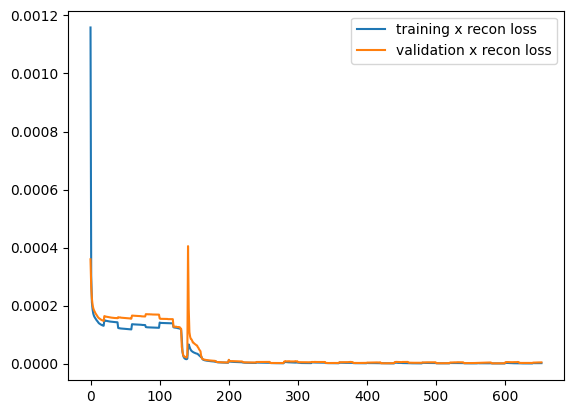

In [20]:
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,3000))
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()

In [22]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_x_ep[:600])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]

581

In [7]:
testepoch=580
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in np.unique(nmco_features_filtered['disease_constric']):
    print(s)
    _, _, testInputnp=imageslist[s]
    
    testInputloader=DataLoader(testInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    loss_x_test_all=0
    for batch_idx, testInput in enumerate(testInputloader):
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = model(testInput)
        
        if adv and (s in list(sampleLabellist_ae.keys())):
            sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
            modelAdv.eval()
            advOut=modelAdv(z)

        loss_x_test_all+=loss_x(recon, testInput).item()
    loss_x_test_all=loss_x_test_all/len(testInputloader.dataset)

    print('test results',
          'loss_x_test: {:.10f}'.format(loss_x_test_all))


Diabetic_compressed
test results loss_x_test: 0.0000040730
Diabetic_control
test results loss_x_test: 0.0000016021
Healthy_compressed
test results loss_x_test: 0.0000035998
Healthy_control
test results loss_x_test: 0.0000013459
Hypertension_compressed
test results loss_x_test: 0.0000027937
Hypertension_control
test results loss_x_test: 0.0000013903
Prediabetic_compressed
test results loss_x_test: 0.0000025956
Prediabetic_control
test results loss_x_test: 0.0000011630


# Get Latent Space Embedding

In [8]:
from tqdm import tqdm
batchsize=1
latent_list=[]
pathalogy=[]
recon_list=[]
patient_id=pd.Series()
where_id=pd.Series()
for s in np.unique(nmco_features_filtered['disease_constric']):
    print(s)
    trainInputnp, valInputnp, testInputnp=imageslist[s]   
    trainInput_id, valInput_id, testInput_id=imagesid[s]
    trainwhere_id, valwhere_id, testwhere_id,=whereid[s]
    full_id=pd.concat([trainInput_id, valInput_id,testInput_id], ignore_index=True)
    full_list=np.concatenate((trainInputnp,valInputnp,testInputnp),axis=0)
    full_where=pd.Series(np.concatenate([trainwhere_id, valwhere_id,testwhere_id], axis=0))
    patient_id=pd.concat([patient_id,full_id],ignore_index=True)
    where_id=pd.concat([where_id,full_where],ignore_index=True)
    testInputloader=DataLoader(full_list, batch_size=batchsize, drop_last=False, shuffle=False)
    loss_x_test_all=0
    for batch_idx, testInput in enumerate(testInputloader):
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = model(testInput)
        z_np=z.cpu().detach().numpy()
        recon=recon.cpu().detach().numpy()
        reconmin=np.min(recon)
        reconmax=np.max(recon)
        recon=(recon-reconmin)/(reconmax-reconmin)
        testInput=testInput.cpu().detach().numpy()
        z_np=pd.DataFrame(z_np)
        
        pathalogy.append(s)
        latent_list.append(z_np)
        recon_list.append(recon)
        
pathalogy = pd.Series(pathalogy) 

batchsize=1
latent_list_test=[]
pathalogy_test=[]
patient_id_test=pd.Series()
recon_list_test=[]
where_id_test=pd.Series()
for s in np.unique(nmco_features_filtered['disease_constric']):
    print(s)
    _, _, testInputnp=imageslist[s]   
    _, _, testInput_id=imagesid[s]
    _, _, testwhere_id,=whereid[s]
#    full_id=pd.concat([testInput_id], ignore_index=True)
#    full_list=np.concatenate((testInputnp),axis=0)
    patient_id_test=pd.concat([patient_id,testInput_id],ignore_index=True)
    where_id_test=pd.concat([where_id,pd.Series(testwhere_id)],ignore_index=True)
    testInputloader=DataLoader(testInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    loss_x_test_all=0
    for batch_idx, testInput in enumerate(testInputloader):
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = model(testInput)
        z_np=z.cpu().detach().numpy()
        recon=recon.cpu().detach().numpy()
        reconmin=np.min(recon)
        reconmax=np.max(recon)
        recon=(recon-reconmin)/(reconmax-reconmin)
        testInput=testInput.cpu().detach().numpy()
        z_np=pd.DataFrame(z_np)
        
        pathalogy_test.append(s)
        latent_list_test.append(z_np)
        recon_list_test.append(recon)
pathalogy_test = pd.Series(pathalogy_test) 


#         fig, axs = plt.subplots(1,2,figsize=(10,5),tight_layout=True) 
#         ax=axs[0]   
#         ax.imshow(testInput[0,0,0:64,0:64],cmap="inferno")
#         for spine in ax.spines.values():
#             spine.set_visible(False)    
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax=axs[1]   
#         ax.imshow(recon[0,0,0:64,0:64],cmap="inferno")
#         for spine in ax.spines.values():
#             spine.set_visible(False)    
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.show()


        


Diabetic_compressed


/tmp/ipykernel_56584/973199185.py:6: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_56584/973199185.py:7: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Diabetic_control
Healthy_compressed
Healthy_control
Hypertension_compressed
Hypertension_control
Prediabetic_compressed
Prediabetic_control


/tmp/ipykernel_56584/973199185.py:41: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_56584/973199185.py:43: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Diabetic_compressed
Diabetic_control
Healthy_compressed
Healthy_control
Hypertension_compressed
Hypertension_control
Prediabetic_compressed
Prediabetic_control


In [9]:
nmco_features_filtered_jumbled=nmco_features_filtered.iloc[where_id]

In [ ]:
with open('pathalogy.pkl', 'wb') as f:
    pickle.dump(pathalogy,f)    
with open('recon_list.pkl', 'wb') as f:
    pickle.dump(recon_list,f)   
with open('latent_list.pkl', 'wb') as f:
    pickle.dump(latent_list,f)  
with open('patient_id.pkl', 'wb') as f:
    pickle.dump(patient_id,f)  
    
with open('pathalogy_test.pkl', 'wb') as f:
    pickle.dump(pathalogy_test,f)    
with open('recon_list_test.pkl', 'wb') as f:
    pickle.dump(recon_list_test,f)   
with open('latent_list_test.pkl', 'wb') as f:
    pickle.dump(latent_list_test,f) 
with open('patient_id_test.pkl', 'wb') as f:
    pickle.dump(patient_id_test,f) 

    